
# KD-Tree vs Radix-Tree Benchmark (JIT)

This notebook compares **KD-tree** and **Radix-tree** timing in three buckets:

1. `build`
2. `traversal`
3. `end-to-end` (`build + traversal`)

## Important comparability note

Traversal workloads are not mathematically identical:

- **KD-tree traversal**: kNN query (`query_neighbors`, `backend="tree"`)
- **Radix-tree traversal**: dual-tree interaction + neighbor-list construction
  (`compute_tree_geometry` + `build_interactions_and_neighbors`)

So treat this as a practical pipeline timing comparison, not exact algorithmic parity.

## JIT note

- KD build/traversal/e2e paths are JIT-wrapped in this notebook.
- Radix build uses `build_tree_jit`, but Radix traversal/e2e are run eagerly to
  avoid current tracer-bool limitations in `compute_tree_geometry` under outer `jax.jit`.


In [1]:

import time
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from yggdrax import (
    DualTreeTraversalConfig,
    build_interactions_and_neighbors,
    build_kdtree,
    build_tree_jit,
    compute_tree_geometry,
    query_neighbors,
)

print('jax:', jax.__version__)
print('device:', jax.devices()[0])


jax: 0.7.2
device: TFRT_CPU_0


In [2]:

@dataclass
class BenchConfig:
    n_points: int = 50_000
    n_queries: int = 4_000
    dim: int = 3
    leaf_size_radix: int = 16
    leaf_size_kd: int = 32
    k_neighbors: int = 8
    theta: float = 0.6
    repeats: int = 5


def make_problem(cfg: BenchConfig, seed: int = 0):
    key = jax.random.PRNGKey(seed)
    key_pos, key_mass, key_q = jax.random.split(key, 3)
    positions = jax.random.uniform(
        key_pos, (cfg.n_points, cfg.dim), minval=-1.0, maxval=1.0, dtype=jnp.float32
    )
    masses = jax.random.uniform(
        key_mass, (cfg.n_points,), minval=0.5, maxval=1.5, dtype=jnp.float32
    )
    queries = jax.random.uniform(
        key_q, (cfg.n_queries, cfg.dim), minval=-1.0, maxval=1.0, dtype=jnp.float32
    )
    return positions, masses, queries


def block_tree_output(x):
    if isinstance(x, tuple):
        jax.tree_util.tree_map(jax.block_until_ready, x)
    else:
        jax.block_until_ready(x)


def timed_call(fn, *args, repeats=5):
    # warmup / compile
    out = fn(*args)
    block_tree_output(out)

    ms = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = fn(*args)
        block_tree_output(out)
        t1 = time.perf_counter()
        ms.append((t1 - t0) * 1e3)
    return out, jnp.asarray(ms)


In [3]:
def run_benchmark(cfg: BenchConfig, seed: int = 0):
    positions, masses, queries = make_problem(cfg, seed=seed)

    traversal_cfg = DualTreeTraversalConfig(
        max_pair_queue=32768,
        process_block=256,
        max_interactions_per_node=4096,
        max_neighbors_per_leaf=4096,
    )

    # Build kernels
    radix_build = jax.jit(
        lambda p, m: build_tree_jit(
            p,
            m,
            leaf_size=cfg.leaf_size_radix,
            return_reordered=True,
        )
    )
    kd_build = jax.jit(lambda p: build_kdtree(p, leaf_size=cfg.leaf_size_kd))

    # Build timing
    (radix_tree, radix_pos_sorted, _, _), t_radix_build = timed_call(
        radix_build, positions, masses, repeats=cfg.repeats
    )
    kd_tree, t_kd_build = timed_call(kd_build, positions, repeats=cfg.repeats)

    # Traversal kernels (build excluded)
    radix_traversal = jax.jit(
        lambda t, ps: build_interactions_and_neighbors(
            t,
            compute_tree_geometry(t, ps),
            theta=cfg.theta,
            mac_type='dehnen',
            traversal_config=traversal_cfg,
        )
    )
    kd_traversal = jax.jit(
        lambda t, q: query_neighbors(
            t,
            q,
            k=cfg.k_neighbors,
            backend='tree',
        )
    )

    _, t_radix_trav = timed_call(
        radix_traversal,
        radix_tree,
        radix_pos_sorted,
        repeats=cfg.repeats,
    )
    _, t_kd_trav = timed_call(kd_traversal, kd_tree, queries, repeats=cfg.repeats)

    # End-to-end kernels (build + traversal)
    radix_e2e = jax.jit(
        lambda p, m: (
            lambda t, ps: build_interactions_and_neighbors(
                t,
                compute_tree_geometry(t, ps),
                theta=cfg.theta,
                mac_type='dehnen',
                traversal_config=traversal_cfg,
            )
        )(*build_tree_jit(p, m, leaf_size=cfg.leaf_size_radix, return_reordered=True)[:2])
    )

    kd_e2e = jax.jit(
        lambda p, q: query_neighbors(
            build_kdtree(p, leaf_size=cfg.leaf_size_kd),
            q,
            k=cfg.k_neighbors,
            backend='tree',
        )
    )

    _, t_radix_e2e = timed_call(radix_e2e, positions, masses, repeats=cfg.repeats)
    _, t_kd_e2e = timed_call(kd_e2e, positions, queries, repeats=cfg.repeats)

    return {
        'radix_build_ms': t_radix_build,
        'kd_build_ms': t_kd_build,
        'radix_traversal_ms': t_radix_trav,
        'kd_traversal_ms': t_kd_trav,
        'radix_e2e_ms': t_radix_e2e,
        'kd_e2e_ms': t_kd_e2e,
    }


In [4]:

cfg = BenchConfig(
    n_points=30_000,
    n_queries=2_000,
    dim=3,
    leaf_size_radix=16,
    leaf_size_kd=32,
    k_neighbors=8,
    theta=0.6,
    repeats=5,
)

stats = run_benchmark(cfg, seed=0)

for k, v in stats.items():
    print(f"{k:>20}: mean={float(jnp.mean(v)):.2f} ms | std={float(jnp.std(v)):.2f} ms | runs={list(map(float, v))}")


      radix_build_ms: mean=9.71 ms | std=0.31 ms | runs=[10.288082994520664, 9.67104104347527, 9.641207987442613, 9.368208004161716, 9.585540974512696]
         kd_build_ms: mean=89.34 ms | std=1.89 ms | runs=[87.87383302114904, 90.35029204096645, 86.67074993718415, 89.71850003581494, 92.06904098391533]
  radix_traversal_ms: mean=657.44 ms | std=16.66 ms | runs=[685.6999580049887, 641.6709589539096, 641.7016669875011, 652.4649580242112, 665.6836250331253]
     kd_traversal_ms: mean=27.52 ms | std=10.54 ms | runs=[21.902458043769002, 22.264125058427453, 22.567874984815717, 22.275542025454342, 48.60329197254032]
        radix_e2e_ms: mean=673.14 ms | std=17.98 ms | runs=[702.1085410378873, 684.3451659660786, 651.8432080047205, 660.4972090572119, 666.9259580085054]
           kd_e2e_ms: mean=101.78 ms | std=1.88 ms | runs=[101.14641592372209, 99.99479202087969, 102.24695794750005, 100.32325005158782, 105.2132910117507]


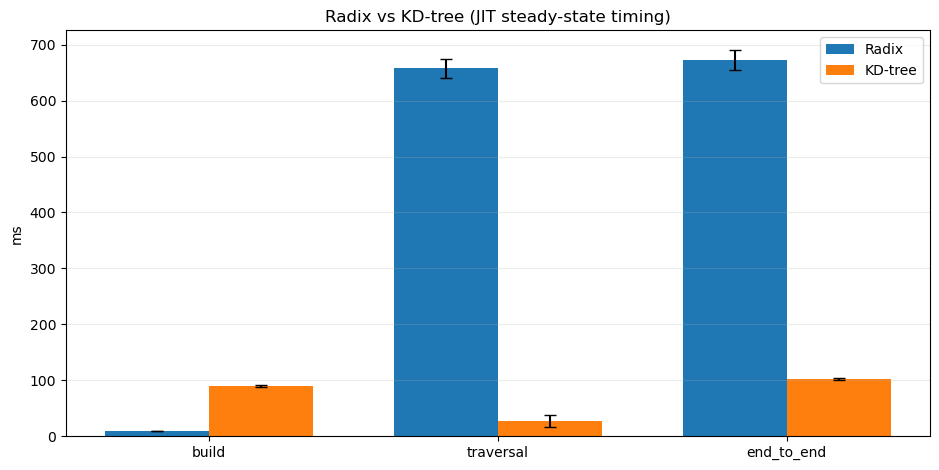

In [5]:

metrics = ['build', 'traversal', 'end_to_end']
radix_means = [
    float(jnp.mean(stats['radix_build_ms'])),
    float(jnp.mean(stats['radix_traversal_ms'])),
    float(jnp.mean(stats['radix_e2e_ms'])),
]
kd_means = [
    float(jnp.mean(stats['kd_build_ms'])),
    float(jnp.mean(stats['kd_traversal_ms'])),
    float(jnp.mean(stats['kd_e2e_ms'])),
]
radix_stds = [
    float(jnp.std(stats['radix_build_ms'])),
    float(jnp.std(stats['radix_traversal_ms'])),
    float(jnp.std(stats['radix_e2e_ms'])),
]
kd_stds = [
    float(jnp.std(stats['kd_build_ms'])),
    float(jnp.std(stats['kd_traversal_ms'])),
    float(jnp.std(stats['kd_e2e_ms'])),
]

x = jnp.arange(len(metrics))
width = 0.36

fig, ax = plt.subplots(figsize=(9.5, 4.8))
ax.bar(x - width / 2, radix_means, width, yerr=radix_stds, capsize=4, label='Radix')
ax.bar(x + width / 2, kd_means, width, yerr=kd_stds, capsize=4, label='KD-tree')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('ms')
ax.set_title('Radix vs KD-tree (JIT steady-state timing)')
ax.grid(axis='y', alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()



## Interpretation tips

- `build`: tree construction cost only.
- `traversal`: operation cost with prebuilt tree.
- `end_to_end`: what one full step costs in a rebuild-each-step workflow.

If your use case rebuilds every optimization step, `end_to_end` usually matters most.


In [ ]:
# KD-tree leaf-size sweep (tree backend)
leaf_sizes = [4, 8, 16, 32, 64]
leaf_sweep = {}

for leaf in leaf_sizes:
    cfg_leaf = BenchConfig(
        n_points=cfg.n_points,
        n_queries=cfg.n_queries,
        dim=cfg.dim,
        leaf_size_radix=cfg.leaf_size_radix,
        leaf_size_kd=leaf,
        k_neighbors=cfg.k_neighbors,
        theta=cfg.theta,
        repeats=max(3, cfg.repeats),
    )
    stats_leaf = run_benchmark(cfg_leaf, seed=0)
    leaf_sweep[leaf] = {
        'kd_build_ms': float(jnp.mean(stats_leaf['kd_build_ms'])),
        'kd_traversal_ms': float(jnp.mean(stats_leaf['kd_traversal_ms'])),
        'kd_e2e_ms': float(jnp.mean(stats_leaf['kd_e2e_ms'])),
    }

print('KD-tree leaf-size sweep (means in ms):')
for leaf in leaf_sizes:
    s = leaf_sweep[leaf]
    print(f"leaf_size={leaf:>2} | build={s['kd_build_ms']:.2f} | traversal={s['kd_traversal_ms']:.2f} | end_to_end={s['kd_e2e_ms']:.2f}")

x = jnp.arange(len(leaf_sizes))
build_vals = [leaf_sweep[l]['kd_build_ms'] for l in leaf_sizes]
trav_vals = [leaf_sweep[l]['kd_traversal_ms'] for l in leaf_sizes]
e2e_vals = [leaf_sweep[l]['kd_e2e_ms'] for l in leaf_sizes]

fig, ax = plt.subplots(figsize=(9.5, 4.8))
ax.plot(x, build_vals, marker='o', label='KD build')
ax.plot(x, trav_vals, marker='o', label='KD traversal')
ax.plot(x, e2e_vals, marker='o', label='KD end-to-end')
ax.set_xticks(x)
ax.set_xticklabels([str(v) for v in leaf_sizes])
ax.set_xlabel('KD leaf_size')
ax.set_ylabel('ms')
ax.set_title('KD-tree performance vs leaf_size')
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()
